# Exploratory Data Analysis

In [13]:
# print pythonPath 
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [20]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from src.data.download import download_dataset

df = download_dataset()

In [15]:
# View first few rows
print(df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Summary statistics
print("\nSummary statistics:\n", df.describe())


  Status_of_existing_checking_account  Duration_in_month Credit_history  \
0                                 A11                  6            A34   
1                                 A12                 48            A32   
2                                 A14                 12            A34   
3                                 A11                 42            A32   
4                                 A11                 24            A33   

  Purpose  Credit_amount Savings_account/bonds Present_employment_since  \
0     A43           1169                   A65                      A75   
1     A43           5951                   A61                      A73   
2     A46           2096                   A61                      A74   
3     A42           7882                   A61                      A74   
4     A40           4870                   A61                      A73   

   Installment_rate_in_percentage_of_disposable_income  \
0                                       

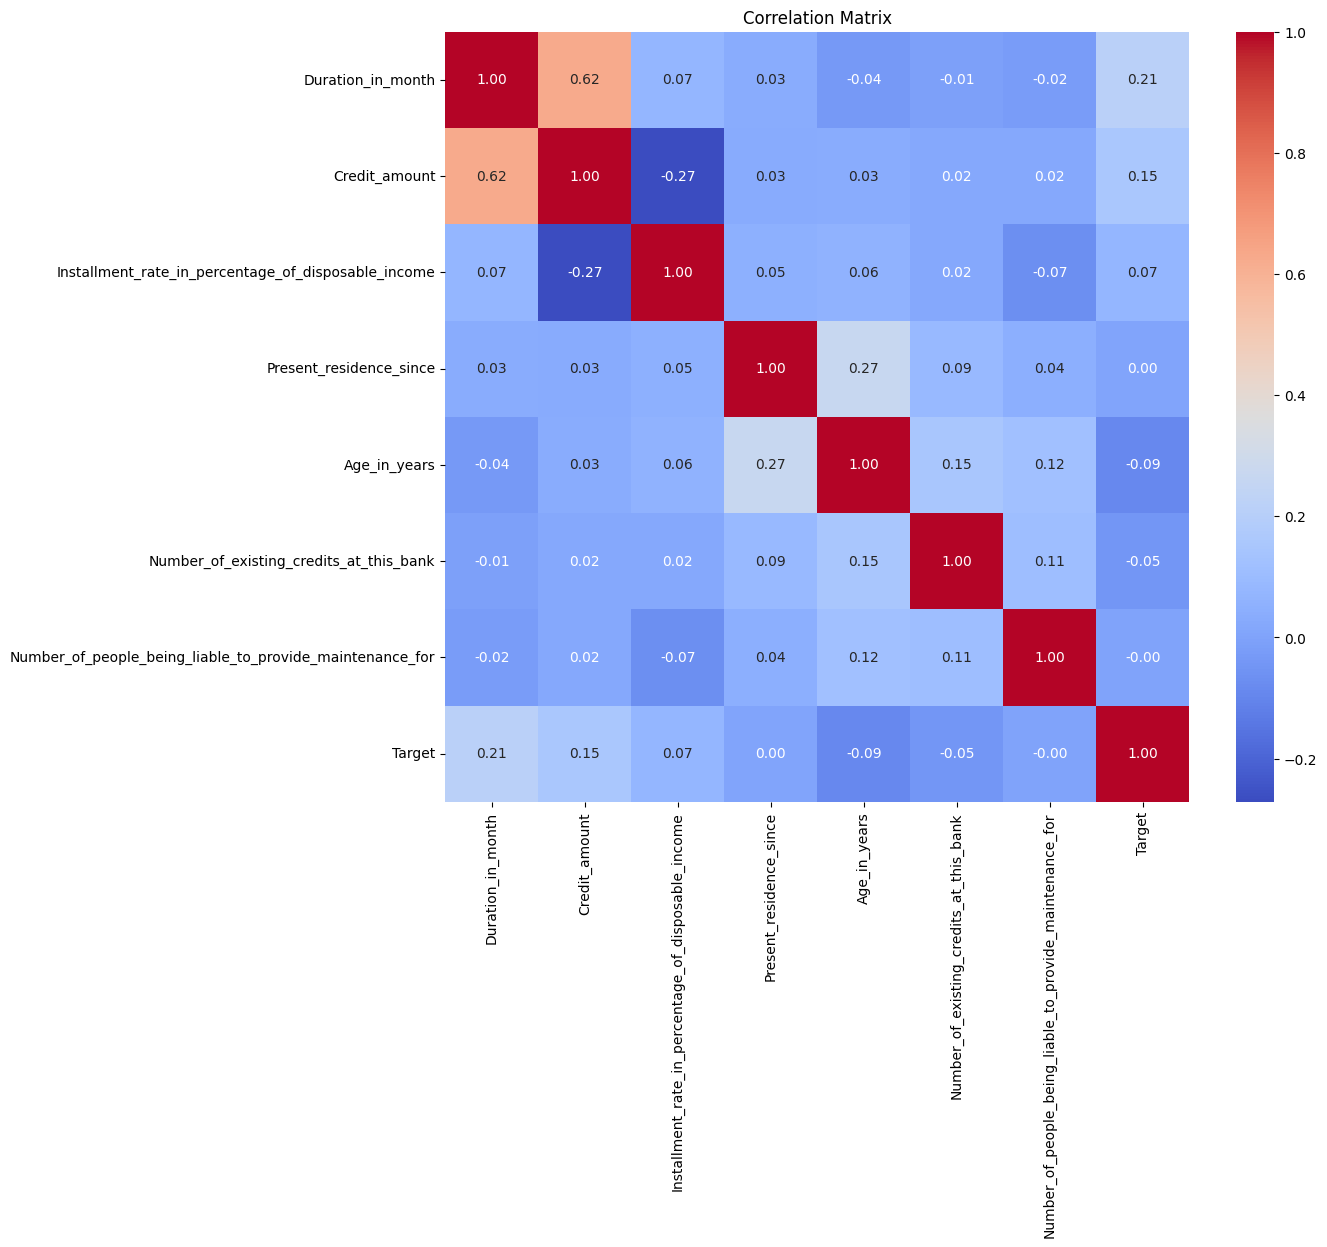

In [22]:
# Convert non-numeric columns to numeric or drop them
df_numeric = df.select_dtypes(include=[float, int])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [24]:
from src.features.feature_engineering import drop_high_corr

df = drop_high_corr(df, corr_matrix)
print(df.head())

In [26]:
from src.models.training import split_data


X_train, X_test, y_train, y_test = split_data(df, "Target")

In [27]:
from src.models.model import create_model
from src.models.training import fit_model

model = create_model()
model = fit_model(model, X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]